In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pyomo.environ import *
import sys
import math
import fractions
import random
import copy
import time
#from copy import deepcopy

from collections import defaultdict

In [2]:
at_colab = "google.colab" in sys.modules

if at_colab:
    import shutil
    if not shutil.which("pyomo"):
        !pip install -q pyomo
        assert(shutil.which("pyomo"))

if at_colab:
    if not shutil.which('/usr/bin/glpsol'):
        !sudo apt install libglpk-dev python3.8-dev libgmp3-dev
        !apt-get install -y -qq glpk-utils
        assert(shutil.which('/usr/bin/glpsol'))

    if not shutil.which('/usr/bin/cbc'):
        !apt-get install -y -qq coinor-cbc
        assert(shutil.which('/usr/bin/cbc'))

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libamd2 libbtf1 libcamd2 libccolamd2 libcholmod3 libcolamd2 libcxsparse3
  libglpk40 libgmp-dev libgmpxx4ldbl libgraphblas-dev libgraphblas6 libklu1
  libldl2 libmetis5 libmongoose2 libpython3.8 libpython3.8-dev
  libpython3.8-minimal libpython3.8-stdlib librbio2 libsliplu1 libspqr2
  libsuitesparse-dev libsuitesparseconfig5 libumfpack5 python3.8
  python3.8-minimal
Suggested packages:
  libiodbc2-dev gmp-doc libgmp10-doc libmpfr-dev python3.8-venv binfmt-support
The following NEW packages will be installed:
  libamd2 libbtf1 libcamd2 libccolamd2 libcholmod3 libcolamd2 libcxsparse3
  libglpk-dev libglpk40 libgmp-dev libgmp3-dev libgmpxx4ldbl libgraphblas-dev
  libgraphblas6 libklu1 libldl2 libmetis5 libmongoose2 libpython3.8
  libpython3.8-dev libpython3.8-minimal libpython3.8-stdlib librbio2
  libsliplu1 libspqr2 libsuitesparse-dev lib

In [3]:
data_file = 'eda08.json'

if 'google.colab' in sys.modules:
    import os
    from google.colab import files
    if not os.path.isfile(data_file):
        uploaded = files.upload()

Saving eda08.json to eda08.json


In [4]:
with open("eda08.json") as f:
    data = json.load(f)

## Sets, parameters and decision variables

In [5]:
days = list(range(data["days"]))
shifts = list(range(3 * data["days"]))
shift_types = data["shift_types"]
skill_levels = list(range(data["skill_levels"]))
age_groups = data["age_groups"]

patients = [p["id"] for p in data["patients"]]
occupants = [o["id"] for o in data["occupants"]]
patients_and_occupants = patients + occupants

rooms = [r["id"] for r in data["rooms"]]
operating_theaters = [t["id"] for t in data["operating_theaters"]]
nurses = [n["id"] for n in data["nurses"]]
surgeons = [u["id"] for u in data["surgeons"]]

In [6]:
length_of_stay = {}
release_day = {}
due_day = {}
mandatory = {}
gender = {}
age_group = {}
incompatible_rooms = {}
surgery_duration = {}
surgeon = {}

seniority_order = [
    "infant", "baby", "child", "young", "adult", "elderly"
]

sorted_age_groups = sorted(age_groups, key=lambda x: seniority_order.index(x))
age_group_map = {name: idx for idx, name in enumerate(sorted_age_groups)}

for p in data["patients"]:
    pid = p["id"]
    length_of_stay[pid] = p["length_of_stay"]
    release_day[pid] = p["surgery_release_day"]
    due_day[pid] = p.get("surgery_due_day", max(days))
    mandatory[pid] = p["mandatory"]
    gender[pid] = p["gender"]
    age_group[pid] = age_group_map[p["age_group"]]
    incompatible_rooms[pid] = sorted(p["incompatible_room_ids"])
    surgery_duration[pid] = p["surgery_duration"]
    surgeon[pid] = p["surgeon_id"]

for o in data["occupants"]:
    oid = o["id"]
    length_of_stay[oid] = o["length_of_stay"]
    gender[oid] = o["gender"]
    age_group[oid] = age_group_map[o["age_group"]]

In [7]:
room_capacity = {r["id"]: r["capacity"] for r in data["rooms"]}
nurse_skill = {n["id"]: n["skill_level"] for n in data["nurses"]}

nurse_shift_set = set()
max_load = {}

for n in data["nurses"]:
    nid = n["id"]
    for s in n["working_shifts"]:
        shift_idx = 3 * s["day"] + shift_types.index(s["shift"])
        max_load[(nid, shift_idx)] = s["max_load"]

workload_raw = {p["id"]: p["workload_produced"] for p in data["patients"]}
skill_required_raw = {p["id"]: p["skill_level_required"] for p in data["patients"]}

for o in data["occupants"]:
    workload_raw[o["id"]] = o["workload_produced"]
    skill_required_raw[o["id"]] = o["skill_level_required"]

occupant_presence = {
    (o["id"], d): 1
    for o in data["occupants"]
    for d in range(o["length_of_stay"])
}

occupant_room = {o["id"]: o["room_id"] for o in data["occupants"]}

ot_availability = {
    (t["id"], d): t["availability"][d]
    for t in data["operating_theaters"]
    for d in range(len(t["availability"]))
}

surgeon_max_surgery_time = {
    (u["id"], d): u["max_surgery_time"][d]
    for u in data["surgeons"]
    for d in range(len(u["max_surgery_time"]))
}

## Waiting list construction

In [8]:
W_mandatory = 100000
W_delay = data["weights"]["patient_delay"]
W_optional = data["weights"]["unscheduled_optional"]
W_skill = data["weights"]["room_nurse_skill"]
W_workload = data["weights"]["nurse_eccessive_workload"]
W_incompat = 5
W_los = 5

In [9]:
priority_scores = {}

for pid in patients:

    urgency = max(days) - release_day[pid]

    wl_values = [workload_raw[(pid, s)] for s in range(length_of_stay[pid]) if (pid, s) in workload_raw]
    skill_values = [skill_required_raw[(pid, s)] for s in range(length_of_stay[pid]) if (pid, s) in skill_required_raw]

    avg_workload = sum(wl_values) / len(wl_values) if wl_values else 0
    avg_skill = sum(skill_values) / len(skill_values) if skill_values else 0

    score = (
        W_mandatory * (1 if mandatory[pid] else 0)
        + W_delay * urgency
        + W_optional * (1 if not mandatory[pid] else 0)
        + W_skill * avg_skill
        + W_workload * avg_workload
        + W_incompat * len(incompatible_rooms[pid])
        + W_los * length_of_stay[pid]
    )

    priority_scores[pid] = score


In [10]:
waiting_list = sorted(patients, key=lambda pid: priority_scores[pid], reverse=True)

## Scheduling procedure

In [11]:
def is_room_compatible(pid, r):
    return r not in incompatible_rooms[pid]

def valid_stay_window(pid, d):
    return release_day[pid] <= d <= due_day[pid]

def room_has_capacity(pid, r, d, room_occupancy):
    for delta in range(length_of_stay[pid]):
        day = d + delta
        if day > max(days):
            continue
        occupants_in_room = sum(
            1 for oid in occupants
            if occupant_room[oid] == r and occupant_presence.get((oid, day), 0) == 1
        )
        total_occupants = room_occupancy.get((r, day), 0) + occupants_in_room
        if total_occupants >= room_capacity[r]:
            return False
    return True

def gender_compatible(pid, r, d, room_gender):
    gender_p = gender[pid]
    for delta in range(length_of_stay[pid]):
        day = d + delta
        if day > max(days):
            continue
        genders_present = room_gender.get((r, day), set()).copy()
        for oid in occupants:
            if occupant_room[oid] == r and occupant_presence.get((oid, day), 0) == 1:
                genders_present.add(gender[oid])
        if genders_present and gender_p not in genders_present:
            return False
    return True

def ot_feasible(pid, t, d, ot_used_time, surgeon_used_time):
    dur = surgery_duration[pid]
    surg = surgeon[pid]
    if ot_used_time.get((t, d), 0) + dur > ot_availability[(t, d)]:
        return False
    if surgeon_used_time.get((surg, d), 0) + dur > surgeon_max_surgery_time[(surg, d)]:
        return False
    return True

def nurses_feasible(pid, r, d, nurse_assignments):
    for delta in range(length_of_stay[pid]):
        day = d + delta
        if day > max(days):
            continue
        for shift_type in shift_types:
            shift_idx = 3 * day + shift_types.index(shift_type)

            nurse_found = False
            for n in nurses:
                if (n, shift_idx) not in max_load:
                    continue
                if r in nurse_assignments.get((n, shift_idx), set()):
                    nurse_found = True
                    break

            if not nurse_found:
                any_nurse_available = False
                for n in nurses:
                    if (n, shift_idx) in max_load and r not in nurse_assignments.get((n, shift_idx), set()):
                        any_nurse_available = True
                        break
                if not any_nurse_available:
                    return False
    return True

In [12]:
def generate_solution(current_list):

    room_occupancy = { (r, d): 0 for r in rooms for d in days }
    room_gender = { (r, d): set() for r in rooms for d in days }
    ot_used_time = { (t, d): 0 for t in operating_theaters for d in days }
    ot_opened = { (t, d): False for t in operating_theaters for d in days }
    surgeon_used_time = { (u, d): 0 for u in surgeons for d in days }
    nurse_load = { (n, s): 0 for n in nurses for s in shifts }
    nurse_assignments = { (n, s): set() for n in nurses for s in shifts }

    admission_day = {}
    assigned_room = {}
    assigned_ot = {}

    for oid in occupants:
        r = occupant_room[oid]
        for day in range(length_of_stay[oid]):
            if occupant_presence.get((oid, day), 0) == 1:
                for shift_type in shift_types:
                    shift_idx = 3 * day + shift_types.index(shift_type)
                    wl = workload_raw.get((oid, shift_idx), 0)
                    if wl > 0:
                        for n in nurses:
                            if r in nurse_assignments[(n, shift_idx)]:
                                nurse_load[(n, shift_idx)] += wl

                room_occupancy[(r, day)] += 1
                room_gender[(r, day)].add(gender[oid])

    for pid in current_list:
        assigned = False
        for d in range(release_day[pid], due_day[pid] + 1):
            if not valid_stay_window(pid, d):
                continue
            for r in rooms:
                if not is_room_compatible(pid, r):
                    continue
                if not room_has_capacity(pid, r, d, room_occupancy):
                    continue
                if not gender_compatible(pid, r, d, room_gender):
                    continue
                for t in operating_theaters:
                    if not ot_feasible(pid, t, d, ot_used_time, surgeon_used_time):
                        continue
                    if not nurses_feasible(pid, r, d, nurse_assignments):
                        continue

                    # Assign patient
                    admission_day[pid] = d
                    assigned_room[pid] = r
                    assigned_ot[pid] = t

                    for delta in range(length_of_stay[pid]):
                        day = d + delta
                        if day > max(days): continue
                        room_occupancy[(r, day)] += 1
                        room_gender[(r, day)].add(gender[pid])

                    ot_used_time[(t, d)] += surgery_duration[pid]
                    ot_opened[(t, d)] = True
                    surgeon_used_time[(surgeon[pid], d)] += surgery_duration[pid]
                    assigned = True
                    break
                if assigned: break
            if assigned: break

    workload = {}
    skill_required = {}

    for pid in admission_day:
        admit_day = admission_day[pid]
        wl = workload_raw[pid]
        sk = skill_required_raw[pid]
        for i in range(len(wl)):
            shift_idx = 3 * admit_day + i
            workload[(pid, shift_idx)] = wl[i]
            skill_required[(pid, shift_idx)] = sk[i]

    for oid in occupants:
        wl = workload_raw[oid]
        sk = skill_required_raw[oid]
        for shift_idx in range(len(wl)):
            day = shift_idx // 3
            if day < length_of_stay[oid] and occupant_presence.get((oid, day), 0) == 1:
                workload[(oid, shift_idx)] = wl[shift_idx]
                skill_required[(oid, shift_idx)] = sk[shift_idx]

    def assign_nurse_to_room(shift_idx, r, workload_needed):
        best_nurse = None
        best_capacity_left = -1

        for n in nurses:
            if (n, shift_idx) in max_load and r not in nurse_assignments[(n, shift_idx)]:
                capacity_left = max_load[(n, shift_idx)] - nurse_load[(n, shift_idx)]
                if capacity_left >= workload_needed:
                    best_nurse = n
                    break
                elif capacity_left > best_capacity_left:
                    best_nurse = n
                    best_capacity_left = capacity_left

        if best_nurse is not None:
            nurse_assignments[(best_nurse, shift_idx)].add(r)
            nurse_load[(best_nurse, shift_idx)] += workload_needed
            return True

        return False

    for day in range(max(days) + 1):
        for shift_type in shift_types:
            shift_idx = 3 * day + shift_types.index(shift_type)
            room_workload = defaultdict(int)

            for pid in admission_day:
                admit_day = admission_day[pid]
                if admit_day <= day < admit_day + length_of_stay[pid]:
                    r = assigned_room[pid]
                    room_workload[r] += workload.get((pid, shift_idx), 0)

            for oid in occupants:
                if occupant_presence.get((oid, day), 0) == 1:
                    r = occupant_room[oid]
                    room_workload[r] += workload.get((oid, shift_idx), 0)

            for r, wl in room_workload.items():
                assign_nurse_to_room(shift_idx, r, wl)

            rooms_with_people = set(room_workload.keys())
            for r in rooms_with_people:
                already_covered = any(r in nurse_assignments[(n, shift_idx)] for n in nurses)
                if not already_covered:
                    assign_nurse_to_room(shift_idx, r, workload_needed=0)

    surgeon_in_ot = defaultdict(bool)

    for pid in admission_day:
        d = admission_day[pid]
        t = assigned_ot[pid]
        u = surgeon[pid]
        surgeon_in_ot[(u, t, d)] = True

    return {
        "admission_day": admission_day,
        "assigned_room": assigned_room,
        "assigned_ot": assigned_ot,
        "nurse_assignments": nurse_assignments,
        "nurse_load": nurse_load,
        "surgeon_in_ot": surgeon_in_ot,
        "ot_opened": ot_opened,
        "workload": workload,
        "skill_required": skill_required
    }

In [13]:
initial_solution = generate_solution(waiting_list)

## Mandatory patients assigned check

In [14]:
unassigned_mandatory = [pid for pid in patients if mandatory[pid] and pid not in initial_solution["admission_day"]]
if unassigned_mandatory:
    print("Could not assign mandatory patients:", unassigned_mandatory)

## Soft constraints check

In [15]:
def compute_age_group_penalty(current_solution, verbose=False):
    from collections import defaultdict

    age_group_max = defaultdict(lambda: 0)
    age_group_min = defaultdict(lambda: 100)
    total_penalty = 0

    for day in days:
        for r in rooms:
            for pid in current_solution['admission_day']:
                admit = current_solution['admission_day'][pid]
                if admit <= day < admit + length_of_stay[pid] and current_solution['assigned_room'][pid] == r:
                    age = age_group[pid]
                    age_group_max[(r, day)] = max(age_group_max[(r, day)], age)
                    age_group_min[(r, day)] = min(age_group_min[(r, day)], age)

            for oid in occupants:
                if occupant_room[oid] == r and occupant_presence.get((oid, day), 0) == 1:
                    age = age_group[oid]
                    age_group_max[(r, day)] = max(age_group_max[(r, day)], age)
                    age_group_min[(r, day)] = min(age_group_min[(r, day)], age)

    for (r, day) in age_group_max:
        min_age = age_group_min[(r, day)]
        max_age = age_group_max[(r, day)]
        penalty = max_age - min_age
        if penalty > 0 and verbose:
            print(f"Day {day}, Room {r}: Age group range {min_age}–{max_age} → Penalty {penalty}")
        total_penalty += penalty

    if verbose:
        print(f"\nTotal Age Group Penalty: {total_penalty}")
    return total_penalty

age_group_penalty = compute_age_group_penalty(initial_solution, verbose=False)

In [16]:
def compute_skill_mismatch_penalty(current_solution, verbose=False):
    total_penalty = 0

    for shift_idx in range(3 * (max(days) + 1)):
        day = shift_idx // 3
        shift_type = shift_types[shift_idx % 3]

        for n in nurses:
            if (n, shift_idx) not in max_load:
                continue

            nurse_skill_level = nurse_skill[n]

            for r in current_solution['nurse_assignments'][(n, shift_idx)]:
                penalty_this_room = 0

                for pid in current_solution['admission_day']:
                    admit = current_solution['admission_day'][pid]
                    if admit <= day < admit + length_of_stay[pid] and current_solution['assigned_room'][pid] == r:
                        required_skill = current_solution['skill_required'].get((pid, shift_idx), 0)
                        penalty = max(0, required_skill - nurse_skill_level)
                        total_penalty += penalty
                        penalty_this_room += penalty

                        if verbose and penalty == 0 and day == 0:
                            print(f"Day {day}, Shift {shift_type}, Room {r}: "
                                  f"Nurse {n} (skill {nurse_skill_level}) underqualified for "
                                  f"patient {pid} requiring skill {required_skill} → Penalty {penalty}")

                for oid in occupants:
                    if occupant_room[oid] == r and occupant_presence.get((oid, day), 0) == 1:
                        required_skill = initial_solution['skill_required'].get((oid, shift_idx), 0)
                        penalty = max(0, required_skill - nurse_skill_level)
                        total_penalty += penalty
                        penalty_this_room += penalty

                        if verbose and penalty == 0 and day == 0:
                          print(f"Day {day}, Shift {shift_type}, Room {r}: "
                            f"Nurse {n} (skill {nurse_skill_level}) underqualified for "
                            f"occupant {oid} requiring skill {required_skill} → Penalty {penalty}")

    if verbose:
        print(f"\nTotal Skill Mismatch Penalty: {total_penalty}")
    return total_penalty

skill_mismatch_penalty = compute_skill_mismatch_penalty(initial_solution, verbose=False)

In [17]:
def compute_continuity_penalty(current_solution, verbose=False):
    ever_assigned = set()

    for shift_idx in range(3 * (max(days) + 1)):
        day = shift_idx // 3
        shift_type = shift_types[shift_idx % 3]

        for n in nurses:
            if (n, shift_idx) not in max_load:
                continue

            nurse_rooms = current_solution['nurse_assignments'][(n, shift_idx)]

            for r in nurse_rooms:
                for pid in current_solution['admission_day']:
                    admit = current_solution['admission_day'][pid]
                    if admit <= day < admit + length_of_stay[pid] and current_solution['assigned_room'][pid] == r:
                        ever_assigned.add((pid, n))
                        if verbose:
                            print(f"Patient {pid} - Nurse {n} assignment in Room {r} on Day {day}, Shift {shift_type}")

                for oid in occupants:
                    if occupant_room[oid] == r and occupant_presence.get((oid, day), 0) == 1:
                        ever_assigned.add((oid, n))
                        if verbose:
                            print(f"Occupant {oid} - Nurse {n} assignment in Room {r} on Day {day}, Shift {shift_type}")

    penalty = len(ever_assigned)
    if verbose:
        print(f"\nTotal Continuity Penalty (unique nurse–patient/occupant pairs): {penalty}")
    return penalty

continuity_penalty = compute_continuity_penalty(initial_solution, verbose=False)

In [18]:
def compute_workload_penalty(current_solution, verbose=False):
    penalty = 0
    for (n, s) in max_load:
        actual = current_solution['nurse_load'][(n, s)]
        allowed = max_load[(n, s)]
        over = max(0, actual - allowed)
        penalty += over
        if verbose and over > 0:
            day = s // 3
            shift_type = shift_types[s % 3]
            print(f"Day {day}, Shift {shift_type}, Nurse {n}: workload = {actual}, max = {allowed} → Penalty {over}")
    if verbose:
        print(f"\nTotal Workload Penalty: {penalty}")
    return penalty

overload_penalty = compute_workload_penalty(initial_solution, verbose=False)

In [19]:
def compute_ot_opening_penalty(current_solution, verbose=False):
    penalty = 0
    for (t, d), opened in current_solution['ot_opened'].items():
        if opened:
            penalty += 1
            if verbose:
                print(f"OT {t} opened on day {d} → +1")
    if verbose:
        print(f"\nTotal OT Opening Penalty: {penalty}")
    return penalty

penalty_ot = compute_ot_opening_penalty(initial_solution, verbose=False)

In [20]:
def compute_surgeon_transfer_penalty(current_solution, verbose=False):
    penalty = 0
    surgeon_day_assignments = {}

    for (u, t, d), present in current_solution['surgeon_in_ot'].items():
        if present:
            surgeon_day_assignments.setdefault((u, d), set()).add(t)

    for (u, d), ots in surgeon_day_assignments.items():
        if len(ots) > 1:
            added_penalty = len(ots) - 1
            penalty += added_penalty
            if verbose:
                print(f"Surgeon {u} assigned to {len(ots)} OTs on Day {d} → +{added_penalty}")
        elif verbose:
            print(f"Surgeon {u} assigned to 1 OT on Day {d} → +0")

    if verbose:
        print(f"\nTotal Surgeon Transfer Penalty: {penalty}")
    return penalty

penalty_surgeon_transfer = compute_surgeon_transfer_penalty(initial_solution, verbose=False)

In [21]:
def compute_delay_penalty(current_solution, verbose=False):
    penalty = 0
    for pid in patients:
        if pid in current_solution['admission_day']:
            delay = current_solution['admission_day'][pid] - release_day[pid]
            if delay > 0:
                penalty += delay
                if verbose:
                    print(f"Patient {pid} admitted on Day {current_solution['admission_day'][pid]}, released Day {release_day[pid]} → Delay {delay} → +{delay}")
    if verbose:
        print(f"\nTotal Delay Penalty: {penalty}")
    return penalty

penalty_delay = compute_delay_penalty(initial_solution, verbose=False)

In [22]:
def compute_unscheduled_optional_penalty(current_solution, verbose=False):
    penalty = 0
    for pid in patients:
        if not mandatory[pid] and pid not in current_solution['admission_day']:
            penalty += 1
            if verbose:
                print(f"Optional patient {pid} not admitted → +1")
    if verbose:
        print(f"\nTotal Unscheduled Optional Penalty: {penalty}")
    return penalty

penalty_optional = compute_unscheduled_optional_penalty(initial_solution, verbose=False)

In [23]:
def compute_unscheduled_mandatory_penalty(current_solution, verbose=False):
    penalty = 0
    for pid in patients:
        if mandatory[pid] and pid not in current_solution['admission_day']:
            penalty += 1
            if verbose:
                print(f"Mandatory patient {pid} not admitted → +1")
    if verbose:
        print(f"\nTotal Unscheduled Mandatory Penalty: {penalty}")
    return penalty

penalty_mandatory = compute_unscheduled_mandatory_penalty(initial_solution, verbose=False)

##Total penalty calculation

In [24]:
W_mixed_age = data["weights"]["room_mixed_age"]
W_skill_mismatch = data["weights"]["room_nurse_skill"]
W_continuity = data["weights"]["continuity_of_care"]
W_overload = data["weights"]["nurse_eccessive_workload"]
W_ot_open = data["weights"]["open_operating_theater"]
W_surgeon_transfer = data["weights"]["surgeon_transfer"]
W_delay = data["weights"]["patient_delay"]
W_optional = data["weights"]["unscheduled_optional"]
W_mandatory = 1000000

In [25]:
def compute_total_penalty(current_solution, verbose = False):

  age_group_penalty = W_mixed_age * compute_age_group_penalty(current_solution)
  skill_mismatch_penalty = W_skill_mismatch * compute_skill_mismatch_penalty(current_solution)
  continuity_penalty = W_continuity * compute_continuity_penalty(current_solution)
  overload_penalty = W_overload * compute_workload_penalty(current_solution)
  ot_opening_penalty = W_ot_open * compute_ot_opening_penalty(current_solution)
  surgeon_transfer_penalty = W_surgeon_transfer * compute_surgeon_transfer_penalty(current_solution)
  delay_penalty = W_delay * compute_delay_penalty(current_solution)
  optional_penalty = W_optional * compute_unscheduled_optional_penalty(current_solution)
  mandatory_penalty = W_mandatory * compute_unscheduled_mandatory_penalty(current_solution)

  total_penalty = (
      age_group_penalty +
      skill_mismatch_penalty +
      continuity_penalty +
      overload_penalty +
      ot_opening_penalty +
      surgeon_transfer_penalty +
      delay_penalty +
      optional_penalty +
      mandatory_penalty
      )

  if verbose:
    print(f"Total penalty: {total_penalty}")

    print(
        f"With individual split:\n"
        f"• Mixed Age Group        → {W_mixed_age} × {compute_age_group_penalty(current_solution)} = {age_group_penalty}\n"
        f"• Skill Mismatch         → {W_skill_mismatch} × {compute_skill_mismatch_penalty(current_solution)} = {skill_mismatch_penalty}\n"
        f"• Continuity             → {W_continuity} × {compute_continuity_penalty(current_solution)} = {continuity_penalty}\n"
        f"• Overload               → {W_overload} × {compute_workload_penalty(current_solution)} = {overload_penalty}\n"
        f"• OT Opening             → {W_ot_open} × {compute_ot_opening_penalty(current_solution)} = {ot_opening_penalty}\n"
        f"• Surgeon Transfer       → {W_surgeon_transfer} × {compute_surgeon_transfer_penalty(current_solution)} = {surgeon_transfer_penalty}\n"
        f"• Delay                  → {W_delay} × {compute_delay_penalty(current_solution)} = {delay_penalty}\n"
        f"• Unscheduled Optionals  → {W_optional} × {compute_unscheduled_optional_penalty(current_solution)} = {optional_penalty}\n"
        f"• Mandatory              → {W_mandatory} × {compute_unscheduled_mandatory_penalty(current_solution)} = {mandatory_penalty}\n"
    )
  return total_penalty

In [26]:
total_penalty = compute_total_penalty(initial_solution, verbose=True)

Total penalty: 19125
With individual split:
• Mixed Age Group        → 5 × 50 = 250
• Skill Mismatch         → 10 × 244 = 2440
• Continuity             → 1 × 525 = 525
• Overload               → 10 × 0 = 0
• OT Opening             → 40 × 12 = 480
• Surgeon Transfer       → 5 × 0 = 0
• Delay                  → 10 × 468 = 4680
• Unscheduled Optionals  → 250 × 43 = 10750
• Mandatory              → 1000000 × 0 = 0



#SA Algorithm

#### Perturbation moves

In [27]:
def reconstruct_ot_usage(solution):
    ot_used_time = {(t, d): 0 for t in operating_theaters for d in days}
    surgeon_used_time = {(u, d): 0 for u in surgeons for d in days}

    for pid in solution["admission_day"]:
        d = solution["admission_day"][pid]
        t = solution["assigned_ot"][pid]
        u = surgeon[pid]
        sd = surgery_duration[pid]

        ot_used_time[(t, d)] += sd
        surgeon_used_time[(u, d)] += sd

    return ot_used_time, surgeon_used_time

def reconstruct_room_state(solution):
    room_occupancy = {(r, d): 0 for r in rooms for d in days}
    room_gender = {(r, d): set() for r in rooms for d in days}

    for pid in solution["admission_day"]:
        admit = solution["admission_day"][pid]
        r = solution["assigned_room"][pid]

        for delta in range(length_of_stay[pid]):
            day = admit + delta
            if day > max(days): continue
            room_occupancy[(r, day)] += 1
            room_gender[(r, day)].add(gender[pid])

    for oid in occupants:
        r = occupant_room[oid]
        for day in range(length_of_stay[oid]):
            if occupant_presence.get((oid, day), 0) == 1:
                room_occupancy[(r, day)] += 1
                room_gender[(r, day)].add(gender[oid])

    return room_occupancy, room_gender

def assign_nurse_to_room(shift_idx, r, workload_needed, nurse_assignments, nurse_load):
    best_nurse = None
    best_capacity_left = -1

    for n in nurses:
        if (n, shift_idx) in max_load and r not in nurse_assignments[(n, shift_idx)]:
            capacity_left = max_load[(n, shift_idx)] - nurse_load[(n, shift_idx)]
            if capacity_left >= workload_needed:
                best_nurse = n
                break
            elif capacity_left > best_capacity_left:
                best_nurse = n
                best_capacity_left = capacity_left

    if best_nurse is not None:
        nurse_assignments[(best_nurse, shift_idx)].add(r)
        nurse_load[(best_nurse, shift_idx)] += workload_needed
        return True

    return False

def reassign_nurses(solution):
    nurse_assignments = {(n, s): set() for n in nurses for s in shifts}
    nurse_load = {(n, s): 0 for n in nurses for s in shifts}

    workload = solution["workload"]
    admission_day = solution["admission_day"]
    assigned_room = solution["assigned_room"]

    for day in days:
        for shift_type in shift_types:
            shift_idx = 3 * day + shift_types.index(shift_type)
            room_workload = defaultdict(int)

            for pid in admission_day:
                admit_day = admission_day[pid]
                if admit_day <= day < admit_day + length_of_stay[pid]:
                    r = assigned_room[pid]
                    room_workload[r] += workload.get((pid, shift_idx), 0)

            for oid in occupants:
                if occupant_presence.get((oid, day), 0) == 1:
                    r = occupant_room[oid]
                    room_workload[r] += workload.get((oid, shift_idx), 0)

            for r, wl in room_workload.items():
                assign_nurse_to_room(shift_idx, r, wl, nurse_assignments, nurse_load)

            for r in room_workload:
                already_covered = any(r in nurse_assignments[(n, shift_idx)] for n in nurses)
                if not already_covered:
                    assign_nurse_to_room(shift_idx, r, 0, nurse_assignments, nurse_load)

    solution["nurse_assignments"] = nurse_assignments
    solution["nurse_load"] = nurse_load
    return solution

In [28]:
def perturb_waiting_list(waiting_list):
    # Swap two random patients in the waiting list
    new_list = waiting_list.copy()
    i, j = random.sample(range(len(waiting_list)), 2)
    new_list[i], new_list[j] = new_list[j], new_list[i]
    return new_list

def perturb_room_assignment(solution):
    # Randomly choose a scheduled patient and reassign them to a different feasible room
    new_solution = copy.deepcopy(solution)

    scheduled_patients = list(new_solution["admission_day"].keys())
    if not scheduled_patients:
        return new_solution

    pid = random.choice(scheduled_patients)
    d = new_solution["admission_day"][pid]
    current_room = new_solution["assigned_room"][pid]

    candidate_rooms = [r for r in rooms if r != current_room and is_room_compatible(pid, r)]
    random.shuffle(candidate_rooms)

    room_occupancy, room_gender = reconstruct_room_state(new_solution)

    for r in candidate_rooms:
        if room_has_capacity(pid, r, d, room_occupancy) and \
           gender_compatible(pid, r, d, room_gender):
            new_solution["assigned_room"][pid] = r
            return new_solution

    return solution

def perturb_admission_day(solution):
    # Randomly choose a scheduled patient and shift their admission day by +/- 1
    new_solution = copy.deepcopy(solution)

    scheduled_patients = list(new_solution["admission_day"].keys())
    if not scheduled_patients:
        return new_solution

    pid = random.choice(scheduled_patients)
    current_day = new_solution["admission_day"][pid]
    direction = random.choice([-1, 1])
    new_day = current_day + direction

    if not (release_day[pid] <= new_day <= due_day[pid]):
        return solution

    r = new_solution["assigned_room"][pid]
    t = new_solution["assigned_ot"][pid]

    room_occupancy, room_gender = reconstruct_room_state(new_solution)
    ot_used_time, surgeon_used_time = reconstruct_ot_usage(new_solution)

    if not room_has_capacity(pid, r, new_day, room_occupancy):
        return solution
    if not gender_compatible(pid, r, new_day, room_gender):
        return solution
    if not ot_feasible(pid, t, new_day, ot_used_time, surgeon_used_time):
        return solution

    new_solution["admission_day"][pid] = new_day
    return new_solution

In [29]:
def acceptance_probability(old_cost, new_cost, temperature):
    if new_cost < old_cost:
        return 1.0
    else:
        return math.exp(-(new_cost - old_cost) / temperature)

In [30]:
def simulated_annealing(waiting_list,
                        target_runtime,
                        initial_temperature=1000,
                        cooling_rate=None,
                        T_min=1,
                        move_weights=(0.6, 0.2, 0.2)):
    current_list = waiting_list
    current_solution = generate_solution(current_list)
    current_cost = compute_total_penalty(current_solution)

    best_list = current_list
    best_solution = current_solution
    best_cost = current_cost

    T = initial_temperature
    iteration = 0

    current_costs = []
    best_costs = []

    if target_runtime == 600:
      eval_iters = 100
    else:
      eval_iters = 1000
    T_cooling_start = T
    t0 = time.time()
    while iteration < eval_iters:
        move_type = random.choices(["swap", "room", "day"], weights=move_weights, k=1)[0]

        if move_type == "swap":
            neighbor_list = perturb_waiting_list(current_list)
            neighbor_solution = generate_solution(neighbor_list)
        elif move_type == "room":
            neighbor_list = current_list
            neighbor_solution = perturb_room_assignment(current_solution)
            neighbor_solution = reassign_nurses(neighbor_solution)
        elif move_type == "day":
            neighbor_list = current_list
            neighbor_solution = perturb_admission_day(current_solution)
            neighbor_solution = reassign_nurses(neighbor_solution)

        neighbor_cost = compute_total_penalty(neighbor_solution)

        if acceptance_probability(current_cost, neighbor_cost, T) > random.random():
            current_list = neighbor_list
            current_solution = neighbor_solution
            current_cost = neighbor_cost

        if neighbor_cost < best_cost:
            best_list = neighbor_list
            best_solution = neighbor_solution
            best_cost = neighbor_cost

        current_costs.append(current_cost)
        best_costs.append(best_cost)

        iteration += 1

    warmup_time = time.time() - t0
    time_per_1000 = warmup_time

    remaining_time = target_runtime - warmup_time
    remaining_steps = remaining_time / time_per_1000
    cooling_rate = (T_min / T_cooling_start) ** (1 / remaining_steps)

    print(f"Adaptive cooling rate estimated: {cooling_rate:.6f} for ~{(target_runtime/60):.0f}min total run time.")

    while T > T_min:
        move_type = random.choices(["swap", "room", "day"], weights=move_weights, k=1)[0]

        if move_type == "swap":
            neighbor_list = perturb_waiting_list(current_list)
            neighbor_solution = generate_solution(neighbor_list)
        elif move_type == "room":
            neighbor_list = current_list
            neighbor_solution = perturb_room_assignment(current_solution)
            neighbor_solution = reassign_nurses(neighbor_solution)
        elif move_type == "day":
            neighbor_list = current_list
            neighbor_solution = perturb_admission_day(current_solution)
            neighbor_solution = reassign_nurses(neighbor_solution)

        neighbor_cost = compute_total_penalty(neighbor_solution)

        if acceptance_probability(current_cost, neighbor_cost, T) > random.random():
            current_list = neighbor_list
            current_solution = neighbor_solution
            current_cost = neighbor_cost

        if neighbor_cost < best_cost:
            best_list = neighbor_list
            best_solution = neighbor_solution
            best_cost = neighbor_cost

        current_costs.append(current_cost)
        best_costs.append(best_cost)

        if target_runtime == 600:
          if iteration % 100 == 0:
              T *= cooling_rate
              print(f"Iteration {iteration}: Best cost = {best_cost}, Current cost = {current_cost}, Temp = {T:.2f}")

        else:
          if iteration % 1000 == 0:
              T *= cooling_rate
              print(f"Iteration {iteration}: Best cost = {best_cost}, Current cost = {current_cost}, Temp = {T:.2f}")

        iteration += 1

    return best_solution, best_cost, current_costs, best_costs

In [31]:
random.seed(4)

best_solution_10min, best_cost_10min, current_costs_10min, best_costs_10min = simulated_annealing(waiting_list, target_runtime=600)
compute_total_penalty(best_solution_10min, verbose=True)

Adaptive cooling rate estimated: 0.875842 for ~10min total run time.
Iteration 100: Best cost = 17887, Current cost = 18309, Temp = 875.84
Iteration 200: Best cost = 17721, Current cost = 17721, Temp = 767.10
Iteration 300: Best cost = 17531, Current cost = 17584, Temp = 671.86
Iteration 400: Best cost = 16998, Current cost = 17393, Temp = 588.44
Iteration 500: Best cost = 16843, Current cost = 17656, Temp = 515.38
Iteration 600: Best cost = 16843, Current cost = 17372, Temp = 451.39
Iteration 700: Best cost = 16843, Current cost = 18102, Temp = 395.35
Iteration 800: Best cost = 16843, Current cost = 17830, Temp = 346.26
Iteration 900: Best cost = 16843, Current cost = 17811, Temp = 303.27
Iteration 1000: Best cost = 16843, Current cost = 17452, Temp = 265.62
Iteration 1100: Best cost = 16843, Current cost = 16972, Temp = 232.64
Iteration 1200: Best cost = 16843, Current cost = 17373, Temp = 203.76
Iteration 1300: Best cost = 16843, Current cost = 17532, Temp = 178.46
Iteration 1400: B

15846

In [32]:
random.seed(5)

best_solution_60min, best_cost_60min, current_costs_60min, best_costs_60min = simulated_annealing(waiting_list, target_runtime=3600)
compute_total_penalty(best_solution_60min, verbose=True)

Adaptive cooling rate estimated: 0.791570 for ~60min total run time.
Iteration 1000: Best cost = 16906, Current cost = 17804, Temp = 791.57
Iteration 2000: Best cost = 16906, Current cost = 17538, Temp = 626.58
Iteration 3000: Best cost = 16906, Current cost = 17716, Temp = 495.98
Iteration 4000: Best cost = 16906, Current cost = 17771, Temp = 392.61
Iteration 5000: Best cost = 16906, Current cost = 17861, Temp = 310.78
Iteration 6000: Best cost = 16707, Current cost = 17728, Temp = 246.00
Iteration 7000: Best cost = 16707, Current cost = 17513, Temp = 194.73
Iteration 8000: Best cost = 16707, Current cost = 17465, Temp = 154.14
Iteration 9000: Best cost = 16478, Current cost = 16764, Temp = 122.01
Iteration 10000: Best cost = 16478, Current cost = 16813, Temp = 96.58
Iteration 11000: Best cost = 16035, Current cost = 17305, Temp = 76.45
Iteration 12000: Best cost = 16035, Current cost = 16730, Temp = 60.52
Iteration 13000: Best cost = 16035, Current cost = 16405, Temp = 47.90
Iteratio

15320

In [33]:
def plot_sa_progress(current_costs, best_costs, save_path=None):
    plt.figure(figsize=(10, 5))

    plt.plot(current_costs, color="black", label="Current penalty")
    plt.plot(best_costs, color="red", linestyle="--", linewidth = 2.5, label="Smallest penalty")

    plt.xlabel("Iteration")
    plt.ylabel("Penalty")
    plt.title("Progress of Simulated Annealing")
    plt.legend()
    plt.grid(False)
    plt.ylim(min(best_costs) * 0.95, max(current_costs) * 1.05)
    plt.xlim(0, len(current_costs))
    plt.tight_layout()

    plt.show()

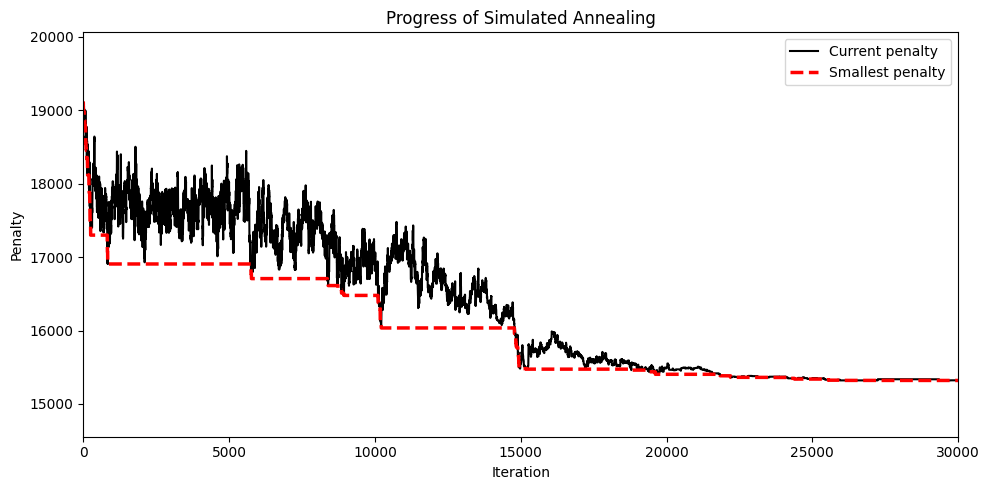

In [34]:
plot_sa_progress(current_costs_60min, best_costs_60min)

In [35]:
def plot_sa_progress_comp(current_costs_10min, best_costs_10min, current_costs_60min, best_costs_60min):
    plt.figure(figsize=(10, 5))

    plt.plot(current_costs_60min, color="#ADD8E6", linewidth = 1, label="Current penalty (60 min)")
    plt.plot(best_costs_60min, color="#00008B", linestyle="--", linewidth = 2.5, label="Smallest penalty (60 min)")
    plt.plot(current_costs_10min, color="#FF0000", linewidth = 1, label="Current penalty (10 min)")
    plt.plot(best_costs_10min, color="#8B0000", linestyle="--", linewidth = 2.5, label="Smallest penalty (10 min)")

    min_penalty_10min = min(best_costs_10min)
    start_x = len(best_costs_10min)
    end_x = max(len(current_costs_60min), len(current_costs_10min))
    plt.hlines(y=min_penalty_10min, xmin=start_x, xmax=end_x,
               color='#FFA07A', linestyle=':', linewidth=2, label='_nolegend_')

    plt.xlabel("Iteration")
    plt.ylabel("Penalty")
    plt.title("Progress of Simulated Annealing")
    plt.legend()
    plt.grid(False)
    plt.ylim(min(best_costs_60min) * 0.95, max(current_costs_10min) * 1.05)
    plt.xlim(0, len(current_costs_60min))
    plt.tight_layout()

    plt.show()

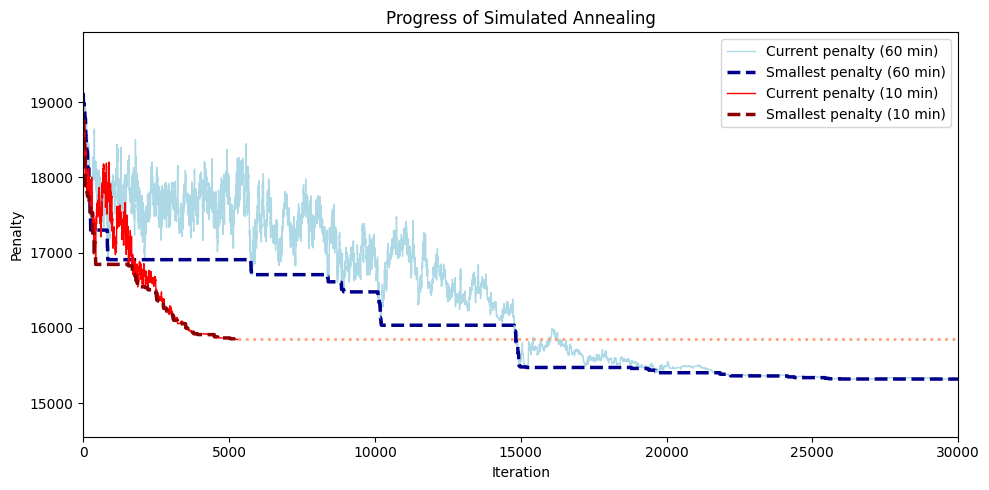

In [36]:
plot_sa_progress_comp(current_costs_10min, best_costs_10min, current_costs_60min, best_costs_60min)

## Export

In [37]:
admission_day = best_solution_60min['admission_day']
nurse_assignments = best_solution_60min['nurse_assignments']
assigned_room = best_solution_60min['assigned_room']
assigned_ot = best_solution_60min['assigned_ot']

In [38]:
patients_output = []

#for pid in patients:              #for visualization
for pid in admission_day:          #for terminal
    patients_output.append({
        "id": pid,
        "admission_day": admission_day.get(pid),
        "room": assigned_room.get(pid),
        "operating_theater": assigned_ot.get(pid)
    })

nurse_schedule = defaultdict(lambda: defaultdict(set))

for (n, shift_idx), rooms in nurse_assignments.items():
    if (n, shift_idx) in max_load:
        day = shift_idx // 3
        shift_type = shift_types[shift_idx % 3]
        nurse_schedule[n][(day, shift_type)].update(rooms)

nurses_output = []

for nurse_id, day_shift_map in nurse_schedule.items():
    assignments = []
    for (day, shift), rooms in sorted(day_shift_map.items()):
        assignments.append({
            "day": day,
            "shift": shift,
            "rooms": sorted(list(rooms))
        })
    nurses_output.append({
        "id": nurse_id,
        "assignments": assignments
    })

solution = {
    "patients": patients_output,
    "nurses": nurses_output
}

with open("solution_eda08_SA_60min.json", "w") as f:
    json.dump(solution, f, indent=4)